# Life Event - Prediction Models

## Introduction
In this notebook we'll be going through an end-to-end project to load in long form transactional type data, prepare the data into a wide format, build some machine learning models, and then deploy those built models. Our long form data contains a feature named `EVENT_TYPE_ID` which contains events that the customer has experienced. In this project we're specifically looking for the events with the prefix `LFE_`. These events are significant <b>life events</b> that have been experienced by the client and we're going to be specifically targeting two life events for this project: `LFE_RELOCATION` and `LFE_HOME_PURHCASE`. We're going to build some machine learning models to help predict the likelihood of these two events occuring for our clients.

## Load Event Data

The easiest way to load in data is to use the <b>Find Data</b> icon in the upper right hand corner. Once selected you will see a sidebar come out with options to load from either local, remote, or other.
<br>
<br>
<img align="left" src="../misc/images/find_data_icon.png" alt="Drawing" style="width: 300px;"/>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

If you loaded your dataset into an Analytics Project, like a CSV file, then select Local and you should be able to find your dataset name. From there you can click the <b>Insert to code</b> and select to either insert a pandas dataframe or a spark dataframe. Once you make the selection you'll see python code inserted into the notebook cell with either Pandas or PySpark code for reading in your data. Now you're ready to explore and manipulate your dataset.

For this project we will be loading in the long form data called `events.csv`. You can execute this notebook with the sample data provided with the project in `../datasets/` directory.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2019. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.<br>**

In [86]:
# import pandas
import pandas as pd
pd.set_option('display.max_columns', 500)
from plotly.plotly import iplot
import plotly as py
py.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Read event data from a CSV file.
# Set data_source to either 'remote' or 'local' to chose which file to use.  The 'remote' option is used if you
# are pulling data from a remote database and followed the steps in the 0-data_import notebook which gets data
# from the database and stages it to a CSV file for processing in this notebook.
data_source = 'local'
if(data_source == 'remote'):
    events = pd.read_csv('../datasets/events_combined.csv', parse_dates=['EVENT_DATE'], dayfirst=True)
else:
    events = pd.read_csv('../datasets/event.csv', parse_dates=['EVENT_DATE'], dayfirst=True)
    
# display the event data
print('\nEvent Data:')
display(events.head())
print("{} rows, {} columns".format(*events.shape))


Event Data:


,CUSTOMER_ID,EVENT_DATE,EVENT_TYPE_ID
0,1103,2013-02-02,INT_OTHER_PHYSICAL
1,1103,2013-02-02,XCT_MORTGAGE_NEW
2,1769,2013-02-03,INT_OTHER_PHYSICAL
3,1769,2013-02-03,XCT_MORTGAGE_NEW
4,1879,2013-02-15,XCT_MORTGAGE_NEW


103426 rows, 3 columns


The `events.csv` data which we loaded has only 5 columns and 103,426 rows. The three main columns to focus on are `CUSTOMER_ID`, `EVENT_DATE`, and `EVENT_TYPE_ID`. This data represents a list of the client experiencing specific events on a given date. We'll take this data and make counts of the events while focusing on the two target life events, home purchase and relocation, and if they occurred.

### Display Distinct Event Types in Data

All of the unique events can be found in the dataset under the feature `EVENT_TYPE_ID`. The wide format dataset will be created from this list of unique events and creating flags and counts on whether a client expereinced the event.

In [31]:
events['EVENT_TYPE_ID'].unique()

array(['INT_OTHER_PHYSICAL', 'XCT_MORTGAGE_NEW',
       'MENTION_LFE_HOME_PURCHASE', 'XCT_EQ_SELL', 'XFER_FUNDS_OUT_LARGE',
       'LFE_RELOCATION', 'LFE_HOME_PURCHASE', 'ACNT_SEC_OPEN_*',
       'BIRTHDAY30', 'INT_LOGIN_WEB', 'BIRTHDAY77', 'BIRTHDAY36',
       'BIRTHDAY51', 'BIRTHDAY59', 'BIRTHDAY22', 'XCT_EQ_BUY',
       'BIRTHDAY55', 'BIRTHDAY47', 'BIRTHDAY58', 'BIRTHDAY43',
       'BIRTHDAY35', 'BIRTHDAY67', 'BIRTHDAY27', 'BIRTHDAY32',
       'BIRTHDAY63', 'BIRTHDAY24', 'BIRTHDAY34', 'BIRTHDAY80',
       'BIRTHDAY21', 'BIRTHDAY82', 'BIRTHDAY29', 'BIRTHDAY81',
       'BIRTHDAY73', 'BIRTHDAY42', 'BIRTHDAY53', 'BIRTHDAY70',
       'BIRTHDAY28', 'BIRTHDAY40', 'BIRTHDAY62', 'BIRTHDAY41',
       'BIRTHDAY74', 'BIRTHDAY69', 'BIRTHDAY64', 'BIRTHDAY44',
       'BIRTHDAY71', 'BIRTHDAY76', 'BIRTHDAY23', 'BIRTHDAY68',
       'BIRTHDAY38', 'BIRTHDAY79', 'BIRTHDAY78', 'BIRTHDAY39',
       'BIRTHDAY37', 'BIRTHDAY45', 'BIRTHDAY54', 'BIRTHDAY25',
       'BIRTHDAY56', 'BIRTHDAY60', 'BIRTHDAY49', 'BI

### Select Life Event Types to Predict

As mentioned above, the focus will be on predicting the two life events `LFE_RELOCATION` and `LFE_HOME_PURCHASE` so we'll filter the `EVENT_TYPE_ID` feature to only those events with the life event prefix of `LFE_`.

In [32]:
# prediction_types = ['LFE_HOME_PURCHASE','LFE_RELOCATION']
prediction_types = [event_type for event_type in list(events['EVENT_TYPE_ID'].unique()) if event_type[:4] == 'LFE_']

print("\nEvent Types to Predict:")
display(prediction_types)
print()


Event Types to Predict:


['LFE_RELOCATION', 'LFE_HOME_PURCHASE']

In [33]:
# this function is called if the user selects to use the supplied census data (b_use_census_data variable)
# it reads in the census and customer data
# the census and customer data are matched based on age, marital status, education, employment status,
# income, location and gender
# the function does cleaning to align category names in each column between customer and census datasets
# returns the prepped dataset along with marriage, migration, birth and divorce probabilities from census data
def prep_census_data(prepped_data):
    
    # read in the census data and the customer data
    df_census_probabilities = pd.read_csv('../datasets/Census Migration Birth Marriage and Divorce Probabilities.csv')
    df_customers = pd.read_csv('../datasets/customer.csv')

    print(df_census_probabilities.head())

    # to join the census data to customer data we map our customer categories to their most similar category in the census data 

    # age ranges in customer data: 23 to 30, 30 to 40, 40 to 55, 55 to 65, 65 and over   
    # age ranges in census data: 18-24, 25-29, 30-34, 35-39, 40-44, 45-54, 55-64, 65-74, 75+, unknown
    # update the census categories to be the same as in the customer data
    age_dict = {'18-24':'18-24', '25-29':'23 to 30', '30-34':'30 to 40', '35-39':'30 to 40', '40-44':'40 to 55', '45-54':'40 to 55', '55-64':'55 to 65', '65-74':'65 and over', '75+':'65 and over', 'Unknown':'Unknown'}
    df_census_probabilities['AGE'] = df_census_probabilities['AGE'].map(age_dict)

    # marital status in customer data: Married, Divorced, 'Single'
    # marrital status in census data: Married, Divorced or Separated, Single, Widoed, Unknown
    # update census 'Divorced or Separated' category to 'Divorced'
    # All other categories can remain the same
    df_census_probabilities['MARITAL_STATUS'] = df_census_probabilities['MARITAL_STATUS'].replace({'Divorced or Separated':'Divorced'})

    # education in customer data: High School, College, Professional, University, PhD
    # education in census data: Grade 11 or Lower, High School, University, Professional Degree, Doctorate Degree, Unknown
    # update 'Professional Degree' category in census data to 'Professional' 
    # update 'Doctorate Degree' category in census data to 'PhD'
    df_census_probabilities['EDUCATION'] = df_census_probabilities['EDUCATION'].replace({'Professional Degree':'Professional',
                                                                                  'Doctorate Degree':'PhD'})
    # update the 'College' category in customer data to 'University'
    df_customers['EDUCATION_LEVEL'] = df_customers['EDUCATION_LEVEL'].replace({'College':'University'})

    # employment status in customer data: Employed, Selfemployed, Homemaker, Retired, Unemployed
    # employment status in census data: Employed, 'Not in Labor Force', Unemployed, Unknown
    # update selfemployed category in customer data to employed
    # update homemaker category in customer data to Not in Labor Force
    # update retired category in customer data to Not in Labor Force
    df_customers['EMPLOYMENT_STATUS'] = df_customers['EMPLOYMENT_STATUS'].replace({'Selfemployed':'Employed'})
    df_customers['EMPLOYMENT_STATUS'] = df_customers['EMPLOYMENT_STATUS'].replace({'Homemaker':'Not in Labor Force'})
    df_customers['EMPLOYMENT_STATUS'] = df_customers['EMPLOYMENT_STATUS'].replace({'Retired':'Not in Labor Force'})

    # income in customer data is numerical
    # income in census data: Under 15k, 15k-35k, 35k-75k, 75k-125k, 125k-200k, 200K+, Unknown,
    # bin income up in the customer data
    bins = [0, 15000, 35000, 75000, 125000, 200000, 9999999999]
    labels = ['Under 15k', '15k-35k', '35k-75k', '75k-125k', '125k-200k', '200K+']
    df_customers['ANNUAL_INCOME'] = pd.cut(df_customers['ANNUAL_INCOME'], bins, labels=labels)

    # states should match between customer and census (where customer data is in USA)
    # set everything else in customer data to 'Unknown' to align with census
    df_customers['LOCATION'] = df_customers['ADDRESS_HOME_STATE']
    df_customers.loc[(~df_customers['ADDRESS_HOME_STATE'].isin(df_census_probabilities['LOCATION'].unique())), 'LOCATION'] = 'Unknown'

    # gender ranges in our customer data are the same as census (ex 'unknown')

    # because of how we grouped above, we can have duplicate records over location, age, marital status, education, employment,
    # gender and income, but with different probabilities
    # to combat this we group by these factors and take an average of the probabilities
    df_census_probabilities = df_census_probabilities.groupby(['LOCATION', 'MARITAL_STATUS', 'EDUCATION', 'GENDER', 'EMPLOYMENT',
           'INCOME', 'AGE'])[['MIGRATION_PROB', 'BIRTH_PROB', 'MARRIAGE_PROB', 'DIVORCE_PROB']].mean().reset_index()

    # join customer and census data on all 7 fields to get the probabilities from census
    # first filter the customer data to return one record per customer
    df_customers = pd.merge(df_customers, df_customers.groupby('CUSTOMER_ID')['EFFECTIVE_DATE'].max().reset_index(), how='inner', on=['CUSTOMER_ID', 'EFFECTIVE_DATE'])

    # get the records that we can match on all 7 criteria
    # mapping above should ensure that all customer records will get a match so we can use an inner join
    df_census_probabilities = pd.merge(df_customers, df_census_probabilities, how='inner', left_on=['AGE_RANGE', 'MARITAL_STATUS', 
                                                                    'EDUCATION_LEVEL', 'EMPLOYMENT_STATUS',
                                                                    'LOCATION', 'ANNUAL_INCOME', 'GENDER'],
                                                        right_on=['AGE', 'MARITAL_STATUS', 
                                                                    'EDUCATION', 'EMPLOYMENT',
                                                                    'LOCATION', 'INCOME', 'GENDER'])

    df_census_probabilities = df_census_probabilities[['CUSTOMER_ID', 'MIGRATION_PROB', 'BIRTH_PROB', 'MARRIAGE_PROB', 'DIVORCE_PROB']]
    
    # replace any missing values with the mean for that column
    df_census_probabilities = df_census_probabilities.fillna(df_census_probabilities.mean())
    
    # loop through the dictionary of prepped data and append the probabilities to the prepped data
    for event_type, df in prepped_data.items():
        prepped_data[event_type] = pd.merge(prepped_data[event_type], df_census_probabilities, on='CUSTOMER_ID')
        prepped_data[event_type].drop('CUSTOMER_ID', axis=1, inplace=True)

    return prepped_data

In [44]:
df_census_probabilities = pd.read_csv('../datasets/Census Migration Birth Marriage and Divorce Probabilities.csv')

In [55]:
cols_to_plot=["LOCATION","MARITAL_STATUS","EDUCATION","GENDER","EMPLOYMENT","INCOME","AGE"]

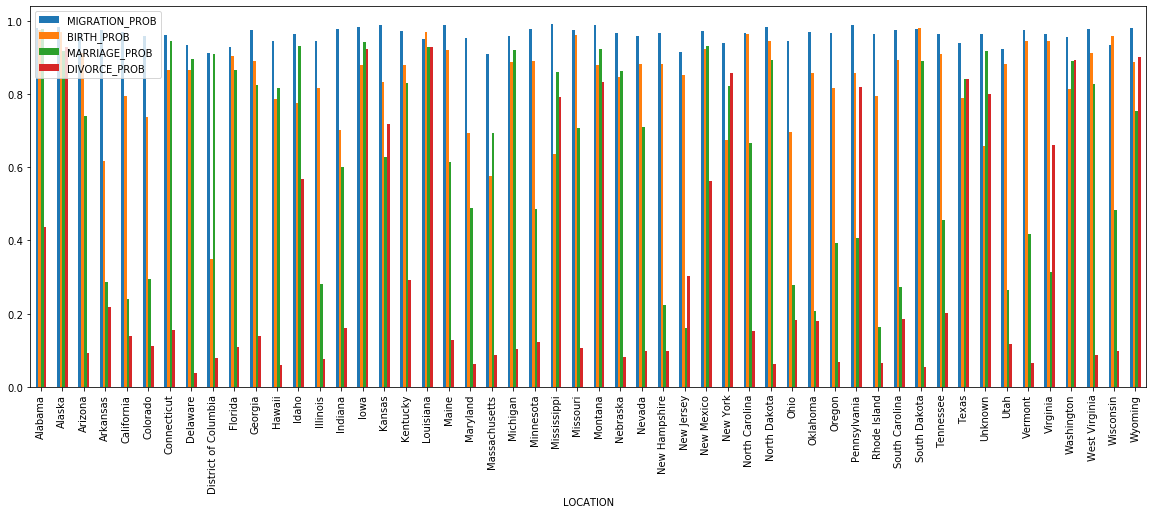

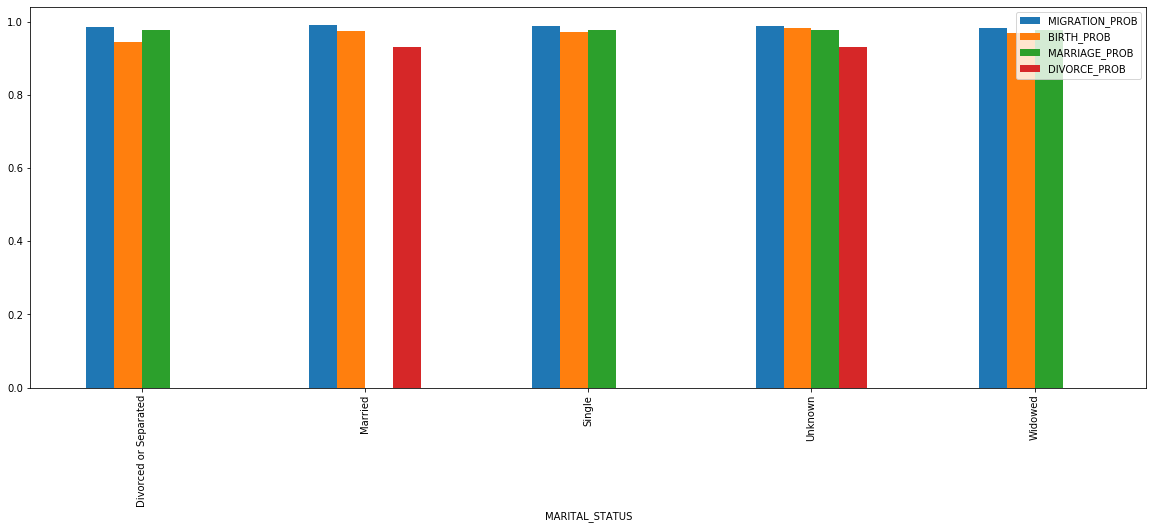

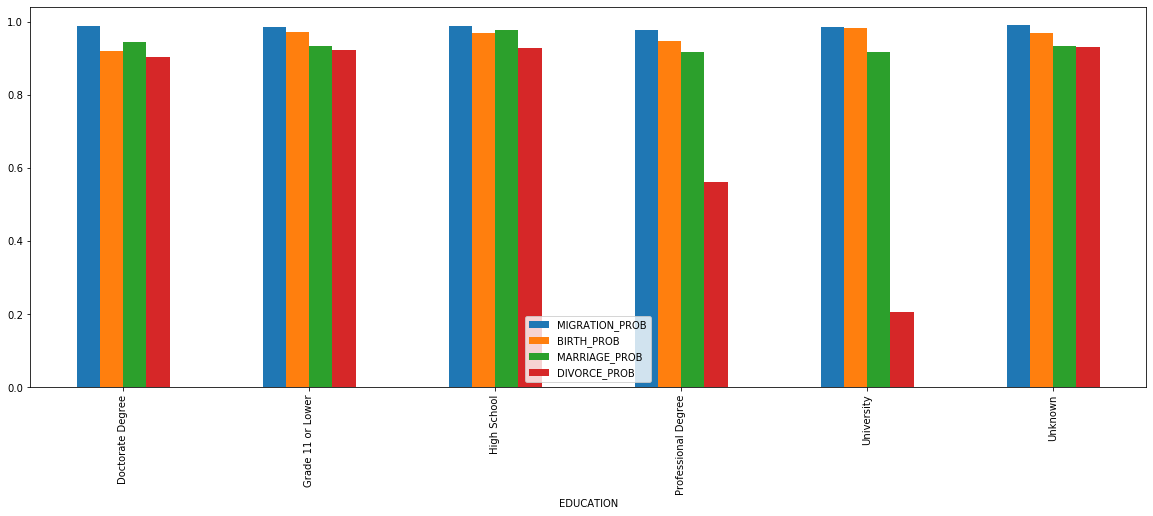

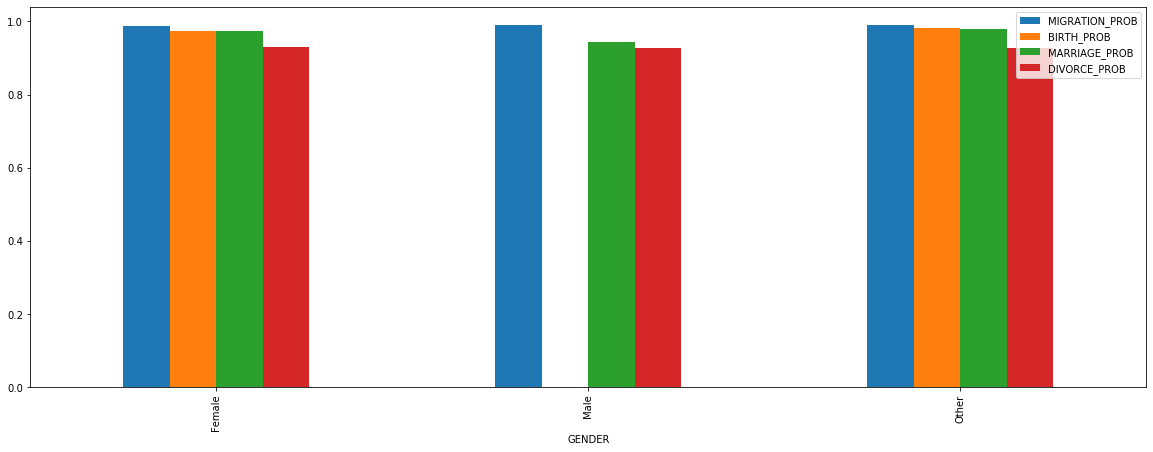

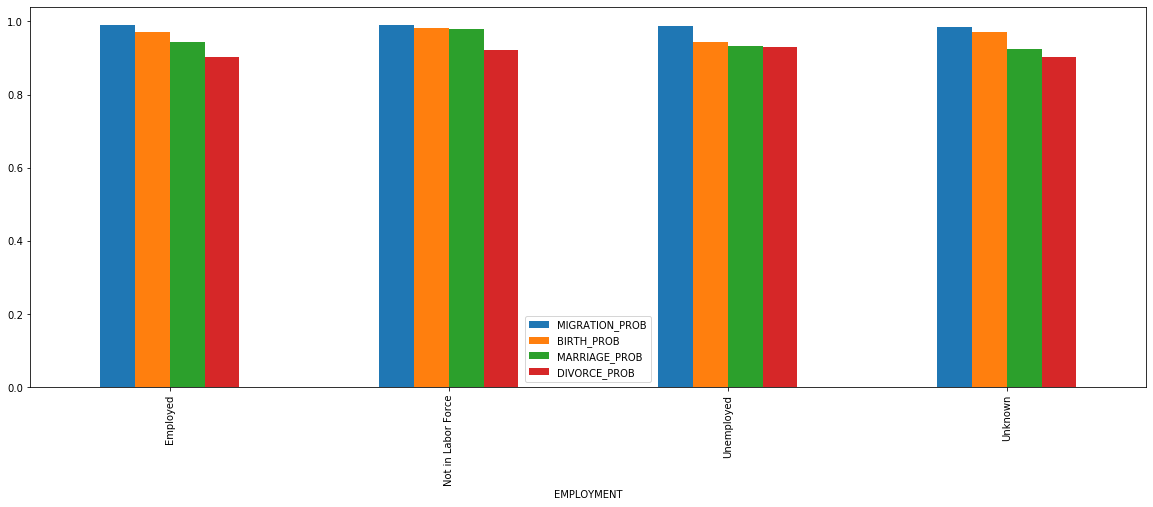

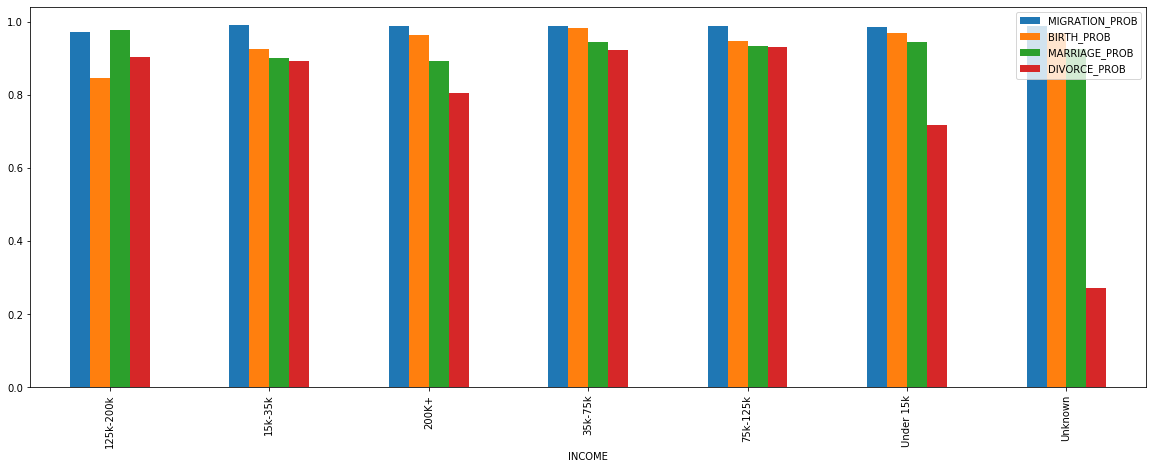

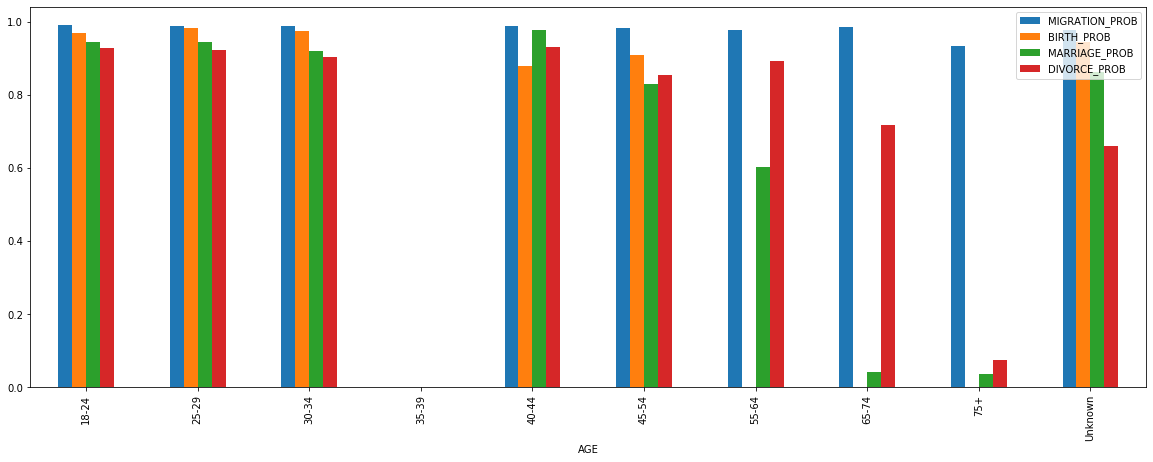

In [61]:
for i in cols_to_plot:
    s=df_census_probabilities.groupby(i).max().reset_index()
    s.plot(x=i, y=["MIGRATION_PROB", "BIRTH_PROB", "MARRIAGE_PROB","DIVORCE_PROB"], kind="bar",figsize=(20,7))

In [99]:
def plot_census(s,column):

    data = [
        go.Bar(
            x=s[column],
            y=s["MIGRATION_PROB"],
            name="MIGRATION_PROB"
        ),
        go.Bar(
            x=s[column],
            y=s["BIRTH_PROB"],
            name="BIRTH_PROB"
        ),
        go.Bar(
            x=s[column],
            y=s["MARRIAGE_PROB"],
            name="MARRIAGE_PROB"
        ),
        go.Bar(
            x=s[column],
            y=s["DIVORCE_PROB"],
            name="DIVORCE_PROB"
        )

    ]

    layout = go.Layout(
        barmode='Bar',
        title='Average Probability by '+column
    )

    fig = dict(data = data, layout = layout)
    py.offline.iplot(fig)



In [92]:
df_census_probabilities.head()

,LOCATION,MARITAL_STATUS,EDUCATION,GENDER,EMPLOYMENT,INCOME,AGE,MIGRATION_PROB,MIGRATION_MOE,BIRTH_PROB,BIRTH_MOE,MARRIAGE_PROB,MARRIAGE_MOE,DIVORCE_PROB,DIVORCE_MOE
0,Unknown,Unknown,Unknown,Other,Unemployed,75k-125k,18-24,0.267777,0.104790,NaN,NaN,0.077514,0.076638,NaN,NaN
1,Unknown,Unknown,Unknown,Other,Unemployed,200K+,55-64,0.106453,0.033842,0.000000,0.000000,0.006033,0.005709,NaN,NaN
2,Unknown,Unknown,Unknown,Male,Unemployed,Unknown,30-34,0.248633,0.005927,0.000000,0.000000,0.030715,0.002537,0.013574,0.001130
3,Unknown,Unknown,Unknown,Male,Unemployed,Under 15k,40-44,0.191099,0.007393,0.000000,0.000000,0.020446,0.002368,0.014445,0.002129
4,Unknown,Unknown,Grade 11 or Lower,Other,Unknown,35k-75k,40-44,0.115484,0.006646,0.003156,0.000984,0.017503,0.002508,0.013814,0.002398


In [106]:
cols_to_plot=["LOCATION","MARITAL_STATUS","EDUCATION","GENDER","EMPLOYMENT","INCOME","AGE"]
for col in cols_to_plot:
    s=df_census_probabilities.groupby(col).mean().reset_index()
    
    #s["BIRTH_PROB"]=s["BIRTH_PROB"]*10
    #s["MARRIAGE_PROB"]=s["MARRIAGE_PROB"]*10
    #s["DIVORCE_PROB"]=s["DIVORCE_PROB"]*10
    plot_census(s,col)

## User Inputs and Data Prep

See `scripts/life_event_prep.py` for details of data preparation

This script generates the dataset which is used as input for model training and scoring purposes. Given a list of events which customers experienced, this script transforms this long form dataset into a wide format, which can be used for modelling.

#### Data Cleaning
A number of functions are carried out throughout the code for cleaning the data. <br>
•	Any customer who does not have at least observation_window + forecast_horizon consecutive months of historical data are filtered out of the training dataset <br>
•	Customers who don’t have any events in their observation_window are also removed from the training dataset <br>
•	Similarly, when scoring, any customer who had no events in the observation window is filtered out <br>
•	Any life event that doesn’t have at least ‘life_event_minimum_target_count’ (default 100) unique customers experiencing it, are removed and not used as a target variable <br>
•	Any column with more than 10% nulls is dropped from training dataset <br>
•	Any columns with a constant value are removed from the training dataset <br>
•	The final scoring dataset is engineered to ensure it has the same columns and order as the training dataset <br>

#### User Inputs for `LifeEventPrep`:
- **target_event_type_ids :**  A list of the life events which we are trying to predict. Single or multiple events can be handled.
- **train_or_score :** Specify whether we are prepping the data for training or for scoring. Training data includes the target variable while scoring dataset will not.
- **training_start_date :** Specify the start date that we start counting events from for training. Variable is a string.
- **training_end_date :** Cut off date for training events. Any events occurring after this date will not be included in training data. Again, the variable is a string.
- **forecast_horizon :** The window of time that we want to predict in. This is the number of months after the observation month in which the event can occur.
- **observation_window :** The lookback period from the observation month. We use the count of number of events which occurred in this window as input variables. Again, this variable is in months.
- **life_event_minimum_target_count :** To include a particular life event target variable, the variable must have at least this number of unique customers associated with it.
- **cols_to_drop**: Columns to be dropped due to known irrelevance to target (e.g. ID column)


- **b_use_census_data**: Boolean variable to allow the user to specify whether they would like to use the supplied census data or not.

In [34]:
import sys
if '../scripts' not in sys.path:
    sys.path.insert(0, '../scripts')


b_use_census_data = True

if b_use_census_data:
    cols_to_drop=[]
else:
    cols_to_drop=['CUSTOMER_ID']
    

from life_event_prep import LifeEventPrep

lfe_prep = LifeEventPrep(target_event_type_ids=prediction_types,
                         train_or_score='train',
                         training_start_date="2010-01-01",
                         training_end_date="2017-08-01",
                         forecast_horizon=3,
                         observation_window=4,
                         life_event_minimum_target_count=100,
                         cols_to_drop=cols_to_drop)

# Prepare Home Purchase and Relocation Data
prepped_data = lfe_prep.prep_data(events, 'train')

# if the user has selected to use the census data call the function to prep the census data and add the probabilities to the prepped data
if b_use_census_data:
    prep_census_data(prepped_data)

Before removing dates that are not in training period : (103426, 3)
After removing dates that are not in training period : (45776, 3)

Number of customers before checking for enough history : 960
Number of customers after  checking for enough history : 789

Total number of events in the data : 44849


2 Target ID(s) left after removing target events below threshold (100 customers)

Prepping data for LFE_RELOCATION
Using observation_window = 4
Using forecast_horizon = 3
Training data has #Target> 1 customers: 0
Training data has #Target==1 customers: 575
   Of those, we set 575 to positive
   and we set 0 to negative
Training data has #Target==0 customers: 214
Number of records : 789
Number of unique customers : 789
Number of customers before removing those with no event data in observation window : 789
Number of customers target=1 before above filtering : 575
Number of customers after removing those with no event data in observation window : 489
Number of customers target=1 after above

### Display Prepared Data

The final dataset contains one record per customer, with variables based on counts of the number of events that a customer had within a specified timeframe, the observation window. All event related variables are prefixed with 'E_'. 

For each event, we get a count of the number of times the customer experienced the event in the observation window. These variables are suffixed with "\_OW". We also create variables for the number of times each customer experienced each event in the observation month (end month in observation window). These variables are suffixed with "\_OM". 

The dataset also contains a target variable indicating whether that customer experienced the life event or not within a particular timeframe, the forecast horizon.

In [35]:
for event_type, df in prepped_data.items():
    print('\nTraining Data for '+event_type+':')
    display(df.head())
    print("{} rows, {} columns\n".format(*df.shape))


Training Data for LFE_RELOCATION:


,E_ACNT_SEC_OPEN_*_OW,E_BIRTHDAY24_OW,E_BIRTHDAY26_OW,E_BIRTHDAY27_OW,E_BIRTHDAY28_OW,E_BIRTHDAY29_OW,E_BIRTHDAY32_OW,E_BIRTHDAY35_OW,E_BIRTHDAY36_OW,E_BIRTHDAY39_OW,E_BIRTHDAY40_OW,E_BIRTHDAY42_OW,E_BIRTHDAY51_OW,E_BIRTHDAY52_OW,E_BIRTHDAY54_OW,E_BIRTHDAY55_OW,E_BIRTHDAY59_OW,E_BIRTHDAY68_OW,E_BIRTHDAY71_OW,E_BIRTHDAY73_OW,E_BIRTHDAY75_OW,E_BIRTHDAY76_OW,E_BIRTHDAY77_OW,E_BIRTHDAY79_OW,E_BIRTHDAY80_OW,E_BIRTHDAY83_OW,E_INT_LOGIN_WEB_OW,E_INT_OTHER_PHYSICAL_OW,E_MENTION_LFE_HOME_PURCHASE_OW,E_XCT_EQ_BUY_OW,E_XCT_EQ_SELL_OW,E_XCT_MORTGAGE_NEW_OW,E_XFER_FUNDS_OUT_LARGE_OW,E_ACNT_SEC_OPEN_*_OM,E_BIRTHDAY24_OM,E_BIRTHDAY27_OM,E_BIRTHDAY28_OM,E_BIRTHDAY39_OM,E_BIRTHDAY55_OM,E_BIRTHDAY68_OM,E_BIRTHDAY73_OM,E_BIRTHDAY77_OM,E_INT_LOGIN_WEB_OM,E_INT_OTHER_PHYSICAL_OM,E_MENTION_LFE_HOME_PURCHASE_OM,E_XCT_EQ_BUY_OM,E_XCT_EQ_SELL_OM,E_XCT_MORTGAGE_NEW_OM,E_XFER_FUNDS_OUT_LARGE_OM,MONTH,TOT_NB_OF_EVENTS_OW,TOT_NB_OF_EVENTS_OM,TARGET,MIGRATION_PROB,BIRTH_PROB,MARRIAGE_PROB,DIVORCE_PROB
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9,1.0,1.0,0,0.149016,0.0,0.0,0.016941
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,16.0,2.0,0,0.036249,0.0,0.0,0.005779
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,2.0,1.0,1,0.061379,0.0,0.0,0.005446
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2.0,0.0,1,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9,1.0,1.0,1,0.231743,0.0,0.0,0.006717


452 rows, 57 columns


Training Data for LFE_HOME_PURCHASE:


,E_ACNT_SEC_OPEN_*_OW,E_BIRTHDAY26_OW,E_BIRTHDAY27_OW,E_BIRTHDAY28_OW,E_BIRTHDAY32_OW,E_BIRTHDAY35_OW,E_BIRTHDAY36_OW,E_BIRTHDAY39_OW,E_BIRTHDAY40_OW,E_BIRTHDAY42_OW,E_BIRTHDAY43_OW,E_BIRTHDAY44_OW,E_BIRTHDAY50_OW,E_BIRTHDAY52_OW,E_BIRTHDAY55_OW,E_BIRTHDAY59_OW,E_BIRTHDAY61_OW,E_BIRTHDAY62_OW,E_BIRTHDAY68_OW,E_BIRTHDAY69_OW,E_BIRTHDAY70_OW,E_BIRTHDAY71_OW,E_BIRTHDAY72_OW,E_BIRTHDAY73_OW,E_BIRTHDAY74_OW,E_BIRTHDAY75_OW,E_BIRTHDAY77_OW,E_BIRTHDAY79_OW,E_BIRTHDAY80_OW,E_BIRTHDAY81_OW,E_BIRTHDAY82_OW,E_INT_LOGIN_WEB_OW,E_INT_OTHER_PHYSICAL_OW,E_LFE_RELOCATION_OW,E_MENTION_LFE_HOME_PURCHASE_OW,E_XCT_EQ_BUY_OW,E_XCT_EQ_SELL_OW,E_XCT_MORTGAGE_NEW_OW,E_XFER_FUNDS_OUT_LARGE_OW,E_ACNT_SEC_OPEN_*_OM,E_BIRTHDAY27_OM,E_BIRTHDAY35_OM,E_BIRTHDAY39_OM,E_BIRTHDAY44_OM,E_BIRTHDAY55_OM,E_BIRTHDAY62_OM,E_BIRTHDAY69_OM,E_BIRTHDAY70_OM,E_BIRTHDAY72_OM,E_BIRTHDAY74_OM,E_BIRTHDAY75_OM,E_BIRTHDAY77_OM,E_BIRTHDAY79_OM,E_BIRTHDAY82_OM,E_INT_LOGIN_WEB_OM,E_INT_OTHER_PHYSICAL_OM,E_LFE_RELOCATION_OM,E_MENTION_LFE_HOME_PURCHASE_OM,E_XCT_EQ_BUY_OM,E_XCT_EQ_SELL_OM,E_XCT_MORTGAGE_NEW_OM,E_XFER_FUNDS_OUT_LARGE_OM,MONTH,TOT_NB_OF_EVENTS_OW,TOT_NB_OF_EVENTS_OM,TARGET,MIGRATION_PROB,BIRTH_PROB,MARRIAGE_PROB,DIVORCE_PROB
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,15.0,3.0,0,0.149016,0.0,0.0,0.016941
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.0,0.0,0,0.062874,0.0,0.0,0.005446
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,7,18.0,4.0,0,0.036249,0.0,0.0,0.005779
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2.0,0.0,1,0.061379,0.0,0.0,0.005446
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,1.0,0.0,1,0.231743,0.0,0.0,0.006717


479 rows, 70 columns



### Splitting the Data
We set up our feature inputs and out outcome variable also called the $X$ and $y$ values. Our $X$ values will be the features we use in our model while $y$ is the output or what we'll try and predict. After we set up the appropriate $X$ and $y$ values then we split our data into train and test data sets using a common 80:20 split with 80% of the data being being used for training our model and 20% being held out to test or validate our model.

When we split our datset we want to do a stratified sampling using our outcome variable with the `stratify=y_output_x` parameter. This ensures that when we split our dataset we maintain the proportions or balance of the outcome variable, `y_output_x`, from the original dataset to within both train and test datasets.

Finally, we set the seed using `random_state=1234` parameter for reproducibility purposes.

In [36]:
from sklearn.model_selection import train_test_split

split_data = {}

for event_type, training_data in prepped_data.items():
    
    X_inputs = training_data.drop(['TARGET'], axis=1)
    y_output = training_data['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X_inputs, y_output, stratify=y_output, test_size=0.20, random_state=1234)
    
    split_data[event_type] = {
        'X_train': X_train, 'y_train': y_train,
        'X_test':  X_test,  'y_test':  y_test
    }

for event_type, splits in split_data.items():
    print("{} Train and Test Data Dimensions:".format(event_type))
    for split, df in splits.items():
        print("{} shape: {}".format(split, df.shape))
    print()

LFE_RELOCATION Train and Test Data Dimensions:
X_train shape: (361, 56)
y_train shape: (361,)
X_test shape: (91, 56)
y_test shape: (91,)

LFE_HOME_PURCHASE Train and Test Data Dimensions:
X_train shape: (383, 69)
y_train shape: (383,)
X_test shape: (96, 69)
y_test shape: (96,)



## Building Machine Learning Models
 The final phase, and the most fun part, is the modeling. We'll train and and validate 3 types of models:<br>
 1. Logistic Regression
 2. Random Forests
 3. Gradient Boosting for Classification
 
For each of these models we'll fit our model and test the model showing accuracy metrics for both the training and testing data. Then we'll look at the confusion matrices, for both train and test data, to see where the model is classifying best across the binary labels. Finally for the random forests and the gradient boosting models we'll look at the variable importance plots. Let's take a look at training these models and their accuracies.

### Model Fitting
First step is to build the classifier and then fit a classifier on your $X$ and $y$ training data for both our datasets, Home Purchase and Relocation. Let's fit the 3 models mentioned above.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = {}
y_scores = {}

for event_type, splits in split_data.items():
    clf = {}
    ys = {}
    
    # Random Forests
    clf['RandomForest'] = RandomForestClassifier(n_estimators=500, max_depth=9, random_state=1234)
    ys['RandomForest'] = clf['RandomForest'].fit(splits['X_train'], splits['y_train'])
    
    # Gradient Boosting
    clf['GradientBoosting'] = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, max_depth=12, random_state=1234)
    ys['GradientBoosting'] = clf['GradientBoosting'].fit(splits['X_train'], splits['y_train'])
    
    # Logistic Regression
    clf['LogisticRegression'] = LogisticRegression(penalty='l1', solver='saga', tol=0.1, random_state=1234)
    ys['LogisticRegression'] = clf['LogisticRegression'].fit(splits['X_train'], splits['y_train'])
    
    # save models and sores to dictionary
    models[event_type] = clf
    y_scores[event_type] = ys

models

{'LFE_RELOCATION': {'RandomForest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=9, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=500,
                         n_jobs=None, oob_score=False, random_state=1234,
                         verbose=0, warm_start=False),
  'GradientBoosting': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                             learning_rate=0.01, loss='deviance', max_depth=12,
                             max_features=None, max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_estimators=500,


### Plot Confusion Matrices
The accuracy looks pretty good, but we also want to see where the model is misclassifying across our binary labels. For that we'll look at our confusion matrix.

**`plot_confusion_matrix`**: This function plots an annotated and more presentable confusion matrix for the classification model results

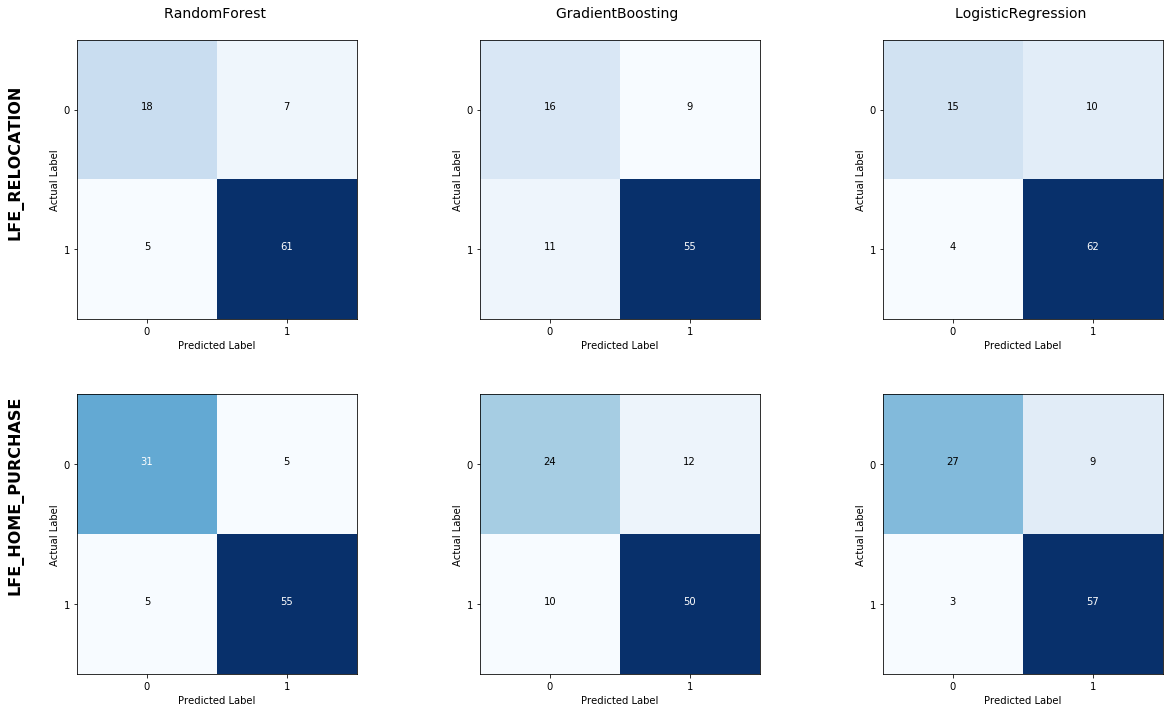

In [38]:
from sklearn import metrics
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Function to plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Iterate over event and model types, calculating and then plotting confusion matrices
fig = plt.figure(figsize=(20,10))
plot = 1
for event_num, (event_type, model_types) in enumerate(models.items()):
    split = split_data[event_type]
    for model_num, (model_type, model) in enumerate(model_types.items()):
        y_pred_test = model.predict(split['X_test'])
        confusion_matrix = metrics.confusion_matrix(split['y_test'], y_pred_test, labels=[0,1])
        
        fig.add_subplot(230+plot)
        if model_num==0:
            plt.text(-1,0.9,event_type, rotation=90, fontsize=16, fontweight="bold")
        plot_confusion_matrix(confusion_matrix, normalize=False, classes=['0','1'], title=(model_type if event_num==0 else '')+' \n')
        plot += 1

### View Model Test Accuracies

After viewing the confusion matrices we can also view the model accuracy on the test dataset across model types and events.

In [39]:
acc = {}
for event_type, model_types in models.items():
    acc[event_type] = {}
    split = split_data[event_type]
    for model_type, model in model_types.items():
        acc[event_type][model_type] = round(model.score(split['X_test'], split['y_test']),4)

print("\nModel Test Accuracy : ")
pd.DataFrame(acc)


Model Test Accuracy : 


,LFE_RELOCATION,LFE_HOME_PURCHASE
GradientBoosting,0.7802,0.7708
LogisticRegression,0.8462,0.8750
RandomForest,0.8681,0.8958


### Select Best Model For Each Event Type

Based on the accuracy metric, select the best model for each event type

In [40]:
best_models = {}
for event_type, model_types in models.items():
    best_models[event_type] = {'accuracy': 0}
    for model_type, model in model_types.items():
        if acc[event_type][model_type] > best_models[event_type]['accuracy']:
            best_models[event_type] = {
                'model_type': model_type,
                'model': models[event_type][model_type],
                'accuracy': acc[event_type][model_type]
            }

print('\nBest Models:')
pd.DataFrame(best_models).T.drop(['model'], axis=1)[['model_type', 'accuracy']]


Best Models:


,model_type,accuracy
LFE_RELOCATION,RandomForest,0.8681
LFE_HOME_PURCHASE,RandomForest,0.8958


### Override Selected Models

If you would like to select a different class of model to be used, set the `override` dict with the event types mapping to the model types you would like to use for the respective event types.

In our case we selected `'RandomForest'` for both models so that we can show explainability during model scoring.

In [41]:
override = {'LFE_RELOCATION': 'GradientBoosting'}

for event_type, model_type in override.items():
    best_models[event_type] = {
        'model_type': model_type,
        'model': models[event_type][model_type],
        'accuracy': acc[event_type][model_type]
    }

print('\nSelected Models:')
pd.DataFrame(best_models).T.drop(['model'], axis=1)[['model_type', 'accuracy']]


Selected Models:


,model_type,accuracy
LFE_RELOCATION,GradientBoosting,0.7802
LFE_HOME_PURCHASE,RandomForest,0.8958


### Plot Feature Importance

With decision tree models you can view variable importance plots. These plots indicate, at the feature level, some importance for the variable to classify the outcome variable. It uses gini importance which looks at node impurity. Node impurity is just looking at how well a tree splits the data.

We'll take a look at the feaure importance plots for the best performing models for both events, Home Purchase and Relocation. Random forest was the top model for both events.

**`plot_feature_importance`**: This plots an annotated and more presentable variable importance plot for the top 10 variables

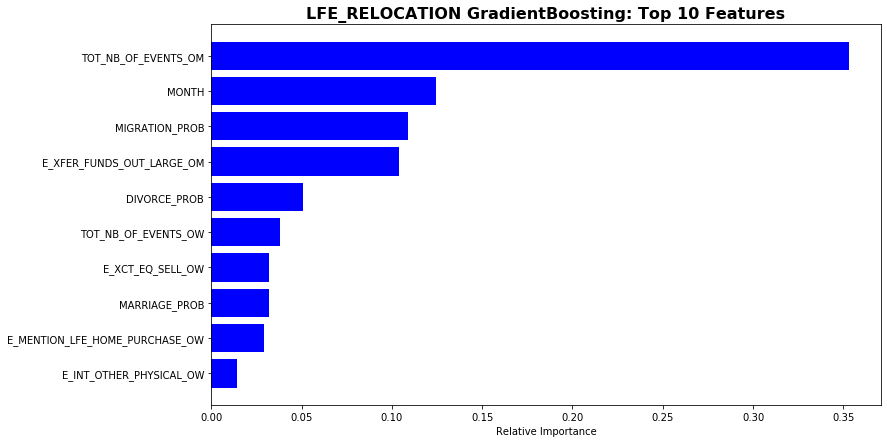

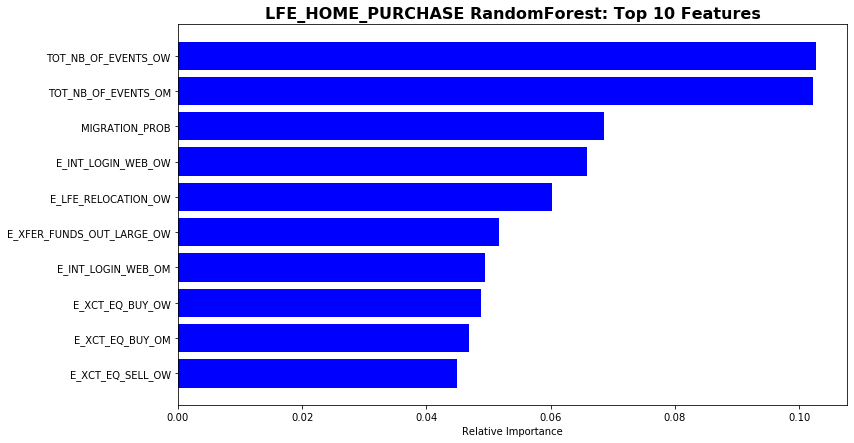

In [42]:
def plot_feature_importance(feature_list, feature_importances, title='Feature Importance Plot'):
    """
    Function to Plot Feature Importances
    """
    features = feature_list
    importances = feature_importances
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=16, fontweight='bold')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    

# Iterate over best models and show features importance if possible
for event_type, best_model in best_models.items():
    if best_model['model_type'] != 'LogisticRegression':
        plot_feature_importance(feature_list=split_data[event_type]['X_train'].columns.tolist(), 
                                feature_importances=best_model['model'].feature_importances_, 
                                title="{} {}: Top 10 Features".format(event_type, best_model['model_type']))

### Save the best classification models to ICP for Data

Finally, we'll save out a single model for each life event based on the `best_models` we set up above using the accuracy metric.

In [43]:
from dsx_ml.ml import save
import pprint

for event_type, best_model in best_models.items():
    model_name = event_type+"_Model"
    resp = save( model=best_model['model'], 
                 name=model_name, 
                 x_test=pd.DataFrame(split_data[event_type]['X_test']), 
                 y_test=pd.DataFrame(split_data[event_type]['y_test']), 
                 algorithm_type='Classification' )
    print("\n{} saved to:\n".format(model_name))
    pprint.pprint(resp)


LFE_RELOCATION_Model saved to:

{'path': '/user-home/1003/DSX_Projects/Life-event-Census/models/LFE_RELOCATION_Model/2',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python36/scikit-learn-0.21/Life-event-Census/LFE_RELOCATION_Model/2'}

LFE_HOME_PURCHASE_Model saved to:

{'path': '/user-home/1003/DSX_Projects/Life-event-Census/models/LFE_HOME_PURCHASE_Model/2',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python36/scikit-learn-0.21/Life-event-Census/LFE_HOME_PURCHASE_Model/2'}


### Operationalize the models

Now we are ready to operationlize our best models. See notebook `2-model_score` for the next step